In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]

In [6]:
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out

In [7]:
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



In [8]:

def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

# plot_integrated_cross_sections(integrated_results)

In [9]:
import math
import torch
import torch.nn as nn
from torch.autograd import Function

# ---------------------------
# Minimal NPReactionSimulator (batched only)
# ---------------------------
class NPReactionSimulator(nn.Module):
    def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
        super().__init__()
        self.register_buffer("m_n", torch.tensor(float(m_n)))
        self.register_buffer("m_p", torch.tensor(float(m_p)))
        self.register_buffer("M_A", torch.tensor(float(M_A)))
        self.register_buffer("S_n", torch.tensor(float(S_n)))
        self.register_buffer("S_p", torch.tensor(float(S_p)))

    def forward(self, Ek, r1, r2, r3):
        # Ek: (B,) or (B,1) -> expand to (B, N)
        if Ek.dim() == 1:
            Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
        elif Ek.shape[1] == 1:
            Ek = Ek.expand(-1, r1.shape[1])

        m_n, m_p, M_A, S_n, S_p = (
            self.m_n.to(Ek),
            self.m_p.to(Ek),
            self.M_A.to(Ek),
            self.S_n.to(Ek),
            self.S_p.to(Ek)
        )

        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2) * m_n / (denom + 1e-12)
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E

        # Ep_com = 0.1 * available_E + 0.9 * r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = 2.0 * r2 - 1.0  # r2 in [0, 1] -> cos(theta) in [-1, 1]
        sin_theta_com = torch.sqrt(torch.clamp(1.0 - cos_theta_com**2, min=0.0))
        phi = 2.0 * torch.pi * r3  # r3 in [0, 1] -> phi in [0, 2π] 

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        beta = torch.clamp(Tk / (M_recoil + 1e-12), max=0.999999)
        gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-12))

        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)
        p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + 1e-12)

        Ep_lab = torch.where(mask, E_lab - m_p, torch.zeros_like(E_lab))
        cos_theta_lab = torch.where(mask, pz_lab / (p_mag_lab + 1e-12), torch.zeros_like(pz_lab))
        return Ep_lab, cos_theta_lab


# ---------------------------
# Differentiable Histogram (much simpler and more stable than KDE)
# ---------------------------
class DifferentiableHistogram(nn.Module):
    def __init__(self, bin_edges, normalize=True):
        super().__init__()
        self.register_buffer("bin_edges", bin_edges.view(-1))
        self.normalize = bool(normalize)
        self.n_bins = len(bin_edges) - 1
        
    def forward(self, samples, weights=None):
        # samples: (B, N)
        B, N = samples.shape
        
        if weights is None:
            weights = torch.ones_like(samples)
        
        # Create histogram using soft binning for differentiability
        bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) / 2
        bin_width = self.bin_edges[1] - self.bin_edges[0]  # Assume uniform bins
        
        # Soft assignment to bins using sigmoid
        # For each sample, compute soft membership to each bin
        samples_expanded = samples.unsqueeze(-1)  # (B, N, 1)
        bin_centers_expanded = bin_centers.view(1, 1, -1)  # (1, 1, n_bins)


                
        tau = getattr(self, "tau", None)
        if tau is None:
            tau = 2.0 * bin_width      # start soft; (larger tau -> softer)
        distances = torch.abs(samples_expanded - bin_centers_expanded)
        soft_assignments = torch.sigmoid((bin_width/2 - distances) / (tau + 1e-12))
                
        # Weight by sample weights
        weights_expanded = weights.unsqueeze(-1)  # (B, N, 1)
        weighted_assignments = soft_assignments * weights_expanded  # (B, N, n_bins)
        
        # Sum over samples to get histogram
        histogram = weighted_assignments.sum(dim=1)  # (B, n_bins)
        
        if self.normalize:
            total_weight = weights.sum(dim=1, keepdim=True).clamp(min=1e-8)
            histogram = histogram / total_weight
        
        return histogram

# ---------------------------
# Minimal Pipeline
# ---------------------------
class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_bins):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.histogram = DifferentiableHistogram(bin_edges=cos_theta_bins, normalize=True)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.histogram(cos_theta_lab, weights=valid)
    
class ECSPipeline(nn.Module):
    def __init__(self, E_bins):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.histogram = DifferentiableHistogram(bin_edges=E_bins, normalize=True)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.histogram(Ep_lab, weights=valid)
    



In [10]:
import torch
import torch.nn.functional as F

def kl_plus_sum_mse_loss(simulated_ddcs, experimental_ddcs, eps=1e-8, mse_weight=0.00001):

    # print(f"simulated_ddcs: {simulated_ddcs.shape}, experimental_ddcs: {experimental_ddcs.shape}")
    # KL (shape)
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    # print(f"sim_sum: {sim_sum.shape}, exp_sum: {exp_sum.shape}")

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    # print(f"sim_dist: {sim_dist.sum()}, exp_dist: {exp_dist.sum()}")

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    kl = F.kl_div(sim_dist.log(), exp_dist, reduction='batchmean', log_target=False)

    # MSE (scale)
    mse_sums = F.mse_loss(sim_sum, exp_sum)

    # Combine
    loss = kl + mse_weight * mse_sums
    return loss

def diversity_loss(t):
    # scale each output dim to mean=0, std=1 before measuring diversity
    t_centered = t - t.mean(dim=1, keepdim=True)
    return -t_centered.std(dim=1).mean()

# Simple MSE loss for normalized distributions
def mse_normalized_loss(sim, exp, eps=1e-8):
    # Ensure both have the same shape and are valid
    sim = torch.clamp(sim, min=eps)
    exp = torch.clamp(exp, min=eps)
    
    # Normalize distributions
    sim_sum = sim.sum(dim=-1, keepdim=True)
    exp_sum = exp.sum(dim=-1, keepdim=True)
    
    sim_norm = sim / (sim_sum + eps)
    exp_norm = exp / (exp_sum + eps)
    
    # MSE between normalized distributions
    mse_loss = torch.mean((sim_norm - exp_norm) ** 2)
    
    # Add a small term to maintain gradients if distributions are too sparse
    sparsity_penalty = 1e-6 * torch.mean(sim)
    
    return mse_loss + sparsity_penalty


In [14]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from tqdm import trange

# # ------------------------------------------------------------------
# # Hyper-parameters
# # ------------------------------------------------------------------
# n_in = 3       # number of parameters (r1, r2, r3)
# n_lamda = 1    # number of external parameters (E_inc)
# n_hidden = 64  # Increased for physics complexity
# n_layers = 4   # Good depth for learning complex distributions
# n_out = n_in   # must match the number of output parameters
# batch_size = 64
# n_mc_samples = 1024
# epochs = 1000
# lr = 1e-3

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # ------------------------------------------------------------------
# # Physics-Optimized Residual MLP
# # ------------------------------------------------------------------
# class PhysicsResidualMLP(nn.Module):
#     """
#     Residual MLP specifically designed for physics Monte Carlo importance sampling.
#     """
#     def __init__(self, n_in, n_lamda, n_hidden, n_layers):
#         super().__init__()
#         self.n_in = n_in
#         self.n_lamda = n_lamda
        
#         input_dim = n_in + n_lamda
        
#         # Input projection with batch norm
#         self.input_proj = nn.Sequential(
#             nn.Linear(input_dim, n_hidden),
#             nn.BatchNorm1d(n_hidden),
#             nn.ReLU(),
#             nn.Dropout(0.1)
#         )
        
#         # Residual blocks
#         self.res_blocks = nn.ModuleList()
#         for i in range(n_layers):
#             block = nn.Sequential(
#                 nn.Linear(n_hidden, n_hidden),
#                 nn.BatchNorm1d(n_hidden),
#                 nn.ReLU(),
#                 nn.Dropout(0.1 if i % 2 == 0 else 0.0),  # Staggered dropout
#                 nn.Linear(n_hidden, n_hidden),
#             )
#             self.res_blocks.append(block)
        
#         # Output projection
#         self.output_proj = nn.Sequential(
#             nn.Linear(n_hidden, n_hidden // 2),
#             nn.ReLU(),
#             nn.Linear(n_hidden // 2, n_in),
#             nn.Sigmoid()
#         )
        
#         self._init_weights()
    
#     def _init_weights(self):
#         """Physics-optimized initialization"""
#         # Initialize residual blocks with small weights
#         for block in self.res_blocks:
#             for layer in block:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.xavier_normal_(layer.weight, gain=0.1)
#                     nn.init.zeros_(layer.bias)

#         # Initialize output to produce values around 0.5 initially
#         nn.init.xavier_normal_(self.output_proj[-2].weight, gain=0.5)
#         nn.init.zeros_(self.output_proj[-2].bias)
    
#     def forward(self, x):
#         """
#         Forward pass that handles both flat and batched inputs
#         """
#         original_shape = x.shape
#         if x.dim() == 3:  # [B, N, features] -> flatten for processing
#             x = x.reshape(-1, x.shape[-1])
        
#         # Input projection
#         h = self.input_proj(x)
        
#         # Residual blocks with small residual weights
#         for i, block in enumerate(self.res_blocks):
#             residual = block(h)
#             # Gradually increase residual strength
#             alpha = 0.05 * (i + 1) / len(self.res_blocks)
#             h = h + alpha * residual
        
#         # Output
#         output = self.output_proj(h)
        
#         # Restore original shape if needed
#         if len(original_shape) == 3:
#             output = output.reshape(original_shape[0], original_shape[1], -1)
        
#         return output

# # ------------------------------------------------------------------
# # Enhanced Loss Function
# # ------------------------------------------------------------------
# def enhanced_physics_loss(dsigma_sim, dsigma_exp, sampled_values, 
#                          lambda_entropy=0.001, lambda_smooth=0.0001):
#     """Enhanced loss function for physics importance sampling"""
    
#     # Primary physics loss (your existing function)
#     mse_loss = mse_normalized_loss(dsigma_sim, dsigma_exp)
    
#     # Entropy regularization - prevent collapse to deterministic sampling
#     batch_size, n_samples, n_dims = sampled_values.shape
    
#     entropy_loss = 0
#     for dim in range(n_dims):
#         dim_samples = sampled_values[:, :, dim]  # [B, N]
#         # Approximate entropy using variance
#         entropy_loss += torch.mean(1.0 / (torch.var(dim_samples, dim=1) + 1e-6))
    
#     # Smoothness regularization
#     smooth_loss = torch.mean(torch.var(sampled_values, dim=1))
    
#     total_loss = mse_loss + lambda_entropy * entropy_loss - lambda_smooth * smooth_loss
    
#     return total_loss, mse_loss, entropy_loss, smooth_loss

# # ------------------------------------------------------------------
# # Learning Rate Scheduler with Warmup
# # ------------------------------------------------------------------
# class WarmupReduceLROnPlateau:
#     """Learning rate scheduler with warmup phase"""
#     def __init__(self, optimizer, warmup_epochs=100, initial_lr=1e-3, **plateau_kwargs):
#         self.optimizer = optimizer
#         self.warmup_epochs = warmup_epochs
#         self.initial_lr = initial_lr
#         self.plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **plateau_kwargs)
#         self.epoch = 0
    
#     def step(self, loss=None):
#         self.epoch += 1
        
#         if self.epoch <= self.warmup_epochs:
#             # Warmup phase
#             lr_scale = self.epoch / self.warmup_epochs
#             for param_group in self.optimizer.param_groups:
#                 param_group['lr'] = self.initial_lr * lr_scale
#         else:
#             # Normal plateau reduction
#             if loss is not None:
#                 self.plateau_scheduler.step(loss)

# # ------------------------------------------------------------------
# # Create Model and Optimizers
# # ------------------------------------------------------------------
# net = PhysicsResidualMLP(n_in, n_lamda, n_hidden, n_layers).to(device)

# # # Use AdamW for better regularization
# # optimiser = optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-4)

# # # Enhanced scheduler with warmup
# # scheduler = WarmupReduceLROnPlateau(
# #     optimiser, 
# #     warmup_epochs=100,
# #     initial_lr=lr,
# #     mode='min',
# #     factor=0.5,
# #     patience=50#,
# #     # verbose=False
# # )

# optimiser = optim.Adam(net.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimiser, mode='min', factor=0.2, patience=300, min_lr=1e-5) #, verbose=True)


# print(f"Physics-optimized model created with {sum(p.numel() for p in net.parameters())} parameters")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import trange

# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in = 3
n_lamda = 1
n_hidden = 64
n_layers = 4
batch_size = 64
n_mc_samples = 1024
epochs = 1000
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------------------------------------
# ResNet-style Blocks
# ------------------------------------------------------------------

def safe_logit(u, eps=1e-6):
    u = u.clamp(min=eps, max=1.0 - eps)
    return torch.log(u) - torch.log1p(-u)

class ResNetBlock(nn.Module):
    def __init__(self, dim, dropout=0.0):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
        )

    def forward(self, x):
        return x + self.block(x)  # residual skip


class UniformPreservingResNet(nn.Module):
    """
    Uniform-preserving MLP with ResNet-style residual blocks in Δ.
    Ensures at init: y = u.
    """
    def __init__(self, n_in, n_lamda, n_hidden, n_layers, n_out=None, eps_logit=1e-6):
        super().__init__()
        if n_out is None:
            n_out = n_in
        assert n_out <= n_in
        self.n_in = n_in
        self.n_lam = n_lamda
        self.n_out = n_out
        self.eps_logit = eps_logit

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(n_in + n_lamda, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.ReLU()
        )

        # Residual correction blocks
        self.res_blocks = nn.ModuleList([
            ResNetBlock(n_hidden, dropout=0.1 if i % 2 == 0 else 0.0)
            for i in range(n_layers)
        ])

        # Output head (Δ)
        self.head = nn.Linear(n_hidden, n_out)
        self._init_weights()

    def _init_weights(self):
        # Small Δ at init → y ≈ u
        nn.init.normal_(self.head.weight, mean=0.0, std=1e-3)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        u = x[..., :self.n_in]
        lam = x[..., self.n_in:self.n_in + self.n_lam]

        h = self.input_proj(torch.cat([u, lam], dim=-1))
        for block in self.res_blocks:
            h = block(h)

        delta = self.head(h)
        u_head = u[..., :self.n_out]
        z = delta + safe_logit(u_head, eps=self.eps_logit)
        return torch.sigmoid(z)


# ------------------------------------------------------------------
# Loss Function (same as before, slightly safer entropy)
# ------------------------------------------------------------------
# def mse_normalized_loss(sim, exp):
#     return torch.mean((sim - exp) ** 2) / (torch.mean(exp ** 2) + 1e-6)

def enhanced_physics_loss(dsigma_sim, dsigma_exp, sampled_values, 
                         lambda_entropy=0.001, lambda_smooth=0.0001):
    mse_loss = mse_normalized_loss(dsigma_sim, dsigma_exp)

    batch_size, n_samples, n_dims = sampled_values.shape
    entropy_loss = 0
    for dim in range(n_dims):
        dim_samples = sampled_values[:, :, dim]
        var = torch.var(dim_samples, dim=1) + 1e-6
        entropy_loss += torch.mean(-torch.log(var))  # smoother entropy surrogate

    smooth_loss = torch.mean(torch.var(sampled_values, dim=1))

    total_loss = mse_loss + lambda_entropy * entropy_loss - lambda_smooth * smooth_loss
    return total_loss, mse_loss, entropy_loss, smooth_loss

# ------------------------------------------------------------------
# LR Scheduler with Warmup
# ------------------------------------------------------------------
class WarmupReduceLROnPlateau:
    def __init__(self, optimizer, warmup_epochs=100, initial_lr=1e-3, **plateau_kwargs):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **plateau_kwargs)
        self.epoch = 0
    
    def step(self, loss=None):
        self.epoch += 1
        if self.epoch <= self.warmup_epochs:
            lr_scale = self.epoch / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = self.initial_lr * lr_scale
        else:
            if loss is not None:
                self.plateau_scheduler.step(loss)

# ------------------------------------------------------------------
# Create Model, Optimizer, Scheduler
# ------------------------------------------------------------------
net = UniformPreservingResNet(n_in, n_lamda, n_hidden, n_layers).to(device)
optimiser = optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-4)
scheduler = WarmupReduceLROnPlateau(
    optimiser,  
    warmup_epochs=100, 
    initial_lr=lr, 
    mode='min', 
    factor=0.5, 
    patience=50
)

print(f"Physics-ResNet model created with {sum(p.numel() for p in net.parameters())} parameters")

Physics-ResNet model created with 34947 parameters


In [15]:

# ------------------------------------------------------------------
# SETUP
# ------------------------------------------------------------------
E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# Create bin edges from experimental data points
cos_theta_bins = torch.linspace(cos_theta_exp.min(), cos_theta_exp.max(), len(cos_theta_exp) + 1)
E_sec_bins = torch.linspace(E_sec_exp.min(), E_sec_exp.max(), len(E_sec_exp) + 1)

# Prep experimental data
all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6 # (N,)

all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, M)
# all_exp = torch.stack([res['int_over_theta'] for res in integrated_results])  # (N, dist_len)

all_Ek = all_Ek.to(device)
all_exp = all_exp.to(device)
num_samples_total = all_Ek.shape[0]

ecs_pipeline = ECSPipeline(E_bins=E_sec_bins).to(device)
acs_pipeline = ACSPipeline(cos_theta_bins=cos_theta_bins).to(device)

acs_pipeline.histogram.tau = 2.0 * (cos_theta_bins[1]-cos_theta_bins[0]).item()
ecs_pipeline.histogram.tau = 2.0 * (E_sec_bins[1]-E_sec_bins[0]).item()


# ------------------------------------------------------------------
# Training Loop
# ------------------------------------------------------------------

# Track losses with enhanced metrics
loss_history = []
mse_history = []
entropy_history = []
epoch_history = []

# Debug toggles (from your original code)
USE_FIXED_IDX = False
FIXED_IDX_VALUE = 0
USE_FIXED_MC = False

# Prepare fixed MC samples if needed
if USE_FIXED_MC:
    fixed_uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

net.train()
print("Starting enhanced training...")
print(f"Initial learning rate: {lr}")

for epoch in trange(epochs, desc='Training Epochs'):

    # ----- Index selection (your original logic) -----
    if USE_FIXED_IDX:
        idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
    else:
        idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

    Ek_batch = all_Ek[idx] / 1e3
    dsigma_dOmega_exp = all_exp[idx]

    # ----- Enhanced MC sampling -----
    if USE_FIXED_MC:
        uniform_samples = fixed_uniform_samples
    else:
        uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

    # ----- Network forward -----
    # Ek_batch: (B,) -> expand to (B, N, 1)
    # uniform_samples: (B, N, n_in)
    Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)
    net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)
    t = net(net_input)
    t = t.clamp(1e-6, 1 - 1e-6)

    # Your physics transformations
    r1 = t[:, :, 0]
    r2 = t[:, :, 1]
    r3 = t[:, :, 2]

    # ----- ACS forward pass -----
    dsigma_dOmega_sim = acs_pipeline(Ek_batch * 1e3, r1, r2, r3)

    # ----- Loss -----
    # total_loss, mse_loss, entropy_loss, smooth_loss = enhanced_physics_loss(
    #     dsigma_dOmega_sim, dsigma_dOmega_exp, t
    # )
    total_loss = mse_normalized_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)

    # Gradient check
    assert total_loss.requires_grad, "Loss got detached — check loss path"

    # ----- Backprop with gradient clipping -----
    optimiser.zero_grad(set_to_none=True)
    total_loss.backward()
    # torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    optimiser.step()

    scheduler.step(total_loss.detach())

    # Your original tau decay logic
    if (epoch+1) % 50 == 0:
        acs_pipeline.histogram.tau = max(0.20 * float(cos_theta_bins[1]-cos_theta_bins[0]),
                                        acs_pipeline.histogram.tau * 0.7)
        ecs_pipeline.histogram.tau = max(0.20 * float(E_sec_bins[1]-E_sec_bins[0]),
                                        ecs_pipeline.histogram.tau * 0.7)

    # Enhanced tracking
    loss_history.append(float(total_loss.detach()))
    # mse_history.append(float(mse_loss.detach()))
    # entropy_history.append(float(entropy_loss.detach()))
    epoch_history.append(epoch)

    # Enhanced logging
    if epoch % 100 == 0:
        # Calculate gradient norm
        total_grad_norm = 0
        for p in net.parameters():
            if p.grad is not None:
                total_grad_norm += p.grad.norm().item() ** 2
        total_grad_norm = total_grad_norm ** 0.5
        
        print(f"Epoch {epoch+1:3d} | "
              f"Total: {total_loss.detach().item():.6f} | "
            #   f"MSE: {mse_loss.detach().item():.6f} | "
            #   f"Entropy: {entropy_loss.detach().item():.4f} | "
              f"Grad: {total_grad_norm:.4f} | "
              f"Sim: {dsigma_dOmega_sim.sum().item():.4f} | "
              f"Exp: {dsigma_dOmega_exp.sum().item():.4f} | "
              f"LR: {optimiser.param_groups[0]['lr']:.1e}")
        
        # Periodic validation check
        if epoch % 200 == 0 and epoch > 0:
            with torch.no_grad():
                net.eval()
                val_samples = uniform_samples[:4]  # Small validation sample
                val_Ek = Ek_batch[:4, None, None].expand(-1, n_mc_samples, 1)
                val_input = torch.cat([val_samples, val_Ek], dim=-1)
                val_t = net(val_input)
                
                print(f"     Sample stats - Mean: {val_t.mean():.3f}, "
                      f"Std: {val_t.std():.3f}, "
                      f"Range: [{val_t.min():.3f}, {val_t.max():.3f}]")
                net.train()

print("Training completed!")

Starting enhanced training...
Initial learning rate: 0.001


Training Epochs:   0%|          | 1/1000 [00:00<12:33,  1.33it/s]

Epoch   1 | Total: 0.000826 | Grad: 0.0043 | Sim: 2.1944 | Exp: 33645.8906 | LR: 1.0e-05


Training Epochs:  10%|█         | 101/1000 [00:52<06:36,  2.27it/s]

Epoch 101 | Total: 0.000366 | Grad: 0.0122 | Sim: 32.5986 | Exp: 31400.7656 | LR: 1.0e-03


Training Epochs:  20%|██        | 201/1000 [01:36<05:55,  2.25it/s]

Epoch 201 | Total: 0.000173 | Grad: 0.0123 | Sim: 37.5955 | Exp: 29999.7734 | LR: 1.0e-03
     Sample stats - Mean: 0.628, Std: 0.338, Range: [0.000, 1.000]


Training Epochs:  30%|███       | 301/1000 [02:17<04:34,  2.54it/s]

Epoch 301 | Total: 0.000142 | Grad: 0.0016 | Sim: 43.0766 | Exp: 31449.7305 | LR: 5.0e-04


Training Epochs:  40%|████      | 401/1000 [02:57<03:51,  2.59it/s]

Epoch 401 | Total: 0.000153 | Grad: 0.0031 | Sim: 45.4096 | Exp: 33859.9492 | LR: 1.3e-04
     Sample stats - Mean: 0.582, Std: 0.371, Range: [0.000, 1.000]


Training Epochs:  50%|█████     | 501/1000 [03:37<03:18,  2.51it/s]

Epoch 501 | Total: 0.000131 | Grad: 0.0016 | Sim: 47.3462 | Exp: 32322.8105 | LR: 6.3e-05


Training Epochs:  60%|██████    | 601/1000 [04:17<02:40,  2.48it/s]

Epoch 601 | Total: 0.000133 | Grad: 0.0078 | Sim: 47.9914 | Exp: 32402.2891 | LR: 6.3e-05
     Sample stats - Mean: 0.579, Std: 0.376, Range: [0.000, 1.000]


Training Epochs:  70%|███████   | 701/1000 [04:56<01:58,  2.53it/s]

Epoch 701 | Total: 0.000125 | Grad: 0.0040 | Sim: 48.1088 | Exp: 32891.1680 | LR: 1.6e-05


Training Epochs:  80%|████████  | 801/1000 [05:36<01:16,  2.58it/s]

Epoch 801 | Total: 0.000134 | Grad: 0.0041 | Sim: 48.0796 | Exp: 33500.5117 | LR: 7.8e-06
     Sample stats - Mean: 0.574, Std: 0.376, Range: [0.000, 1.000]


Training Epochs:  90%|█████████ | 901/1000 [06:15<00:38,  2.55it/s]

Epoch 901 | Total: 0.000122 | Grad: 0.0014 | Sim: 48.3372 | Exp: 32658.4043 | LR: 3.9e-06


Training Epochs: 100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]

Training completed!


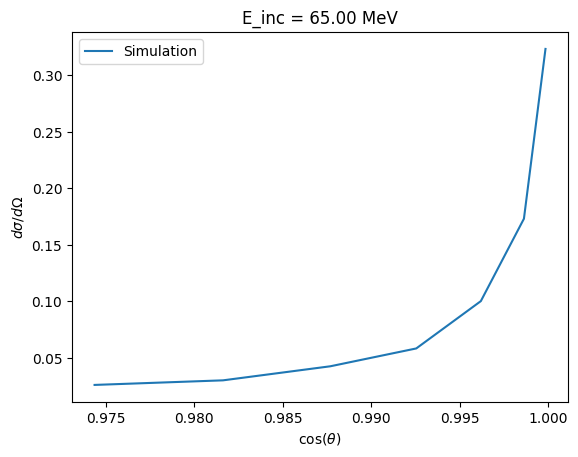

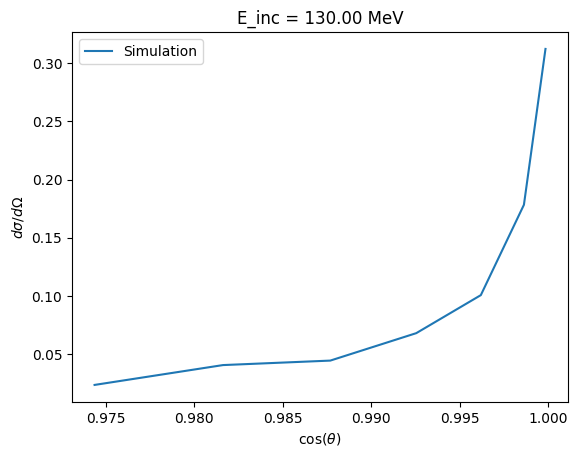

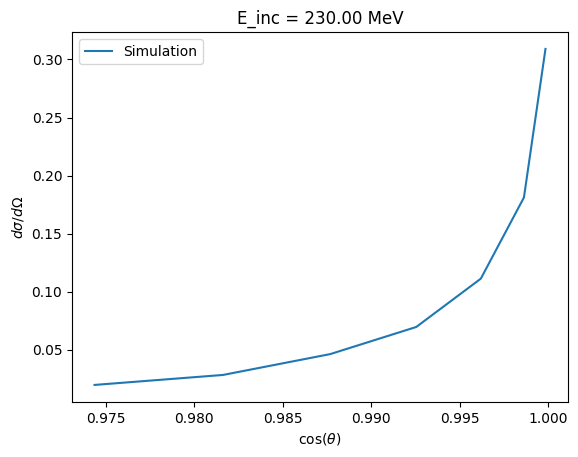

In [19]:
import torch
import matplotlib.pyplot as plt

net.eval()

n_mc_samples = 2000
monitor_indices = [0, len(integrated_results) // 2, -1]  # pick a few energies


for idx in monitor_indices:
    # Experimental values
    Ek_val = integrated_results[idx]['E_inc'] / 1e6  # scalar tensor

    exp_dist = integrated_results[idx]['int_over_E_sec'].to(device)  # (M,)
    # exp_dist = integrated_results[idx]['int_over_theta'].to(device)  # (M,)

    # Shape (B=1, N) for Monte Carlo
    Ek_batch = Ek_val.unsqueeze(0).to(device)  # (1,)
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples)  # (1, N)

    # Random latent samples: (B=1, N, n_in)
    uniform_samples = torch.rand((1, n_mc_samples, n_in), device=device)

    # Append Ek to each MC sample row: (1, N, n_in+1)
    net_input = torch.cat([uniform_samples, Ek_expanded.unsqueeze(-1)], dim=-1)

    # Flatten for net: (B*N, n_in+1)
    net_input_flat = net_input.reshape(-1, n_in + 1)

    with torch.no_grad():
        t = net(net_input_flat).reshape(1, n_mc_samples, 3)
        r1 = t[:, :, 0]
        r2 = t[:, :, 1] #* 2 - 1
        r3 = t[:, :, 2] #* 2 * torch.pi - torch.pi

        # Now acs_pipeline gets (B=1, N) inputs for r1, r2, r3
        sim_dist = acs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)
        # sim_dist = ecs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)


    # Plot
    plt.figure()
    # plt.plot(cos_theta_exp.cpu(), exp_dist.cpu(), label='Experimental')
    plt.plot(cos_theta_exp.cpu(), sim_dist.cpu(), label='Simulation')
    plt.xlabel(r'$\cos(\theta)$')

    # plt.plot(E_sec_exp.cpu(), exp_dist.cpu(), label='Experimental')
    # plt.plot(E_sec_exp.cpu(), sim_dist.cpu(), label='Simulation')
    # plt.xlabel(r'$E_{\text{sec}}$ [MeV]')
    
    plt.ylabel(r'$d\sigma/d\Omega$')
    plt.title(f'E_inc = {Ek_val.item():.2f} MeV')
    plt.legend()
    plt.show()
